Utilise les embeddings de designation et de predictions pour générer une prédiction: sur le texte seulement


In [3]:
import os

import importlib

import RktnChallenge.RktnModel
importlib.reload(RktnChallenge.RktnModel)
from RktnChallenge.RktnModel import ModelTrainer

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam,Adagrad
import numpy as np
import ast

In [4]:

# PARAMS  de base
PATH = "images/crop224/"
img_size = 224
depth = 3

from RktnChallenge.RktnModel import ModelTrainer

trainer = ModelTrainer("embeddings_final.csv",PATH)

list_tags = trainer.data.prdtypecode.unique().tolist()
num_categories = len(list_tags)

X_data = trainer.data[["embeddings_desi","embeddings_desc","embedding_vit"]]

def convert_string_to_nparray(s):    
    # Supprime les caractères non désirés et divise la chaîne en une liste de nombres
    numbers = [float(x) for x in s.replace("[", "").replace("]", "").split()]
    return np.array(numbers)
def translate_string_to_array(s):
    liste_python = ast.literal_eval(s)
    return np.array(liste_python)

X_data.loc[:, 'embeddings_desc'] = X_data['embeddings_desc'].apply(convert_string_to_nparray)
X_data.loc[:, 'embeddings_desi'] = X_data['embeddings_desi'].apply(convert_string_to_nparray)


y = trainer.encodeLabel("prdtypecode")
label_size = trainer.getLabelSize()


In [5]:

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size = 0.20, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.10, random_state = 42)
X1_train = X_train["embeddings_desi"].values
X1_train = np.stack(X1_train).astype(np.float32)
X2_train = X_train["embeddings_desc"].values
X2_train = np.stack(X2_train).astype(np.float32)

X1_val = X_val["embeddings_desi"].values
X1_val = np.stack(X1_val).astype(np.float32)
X2_val = X_val["embeddings_desc"].values
X2_val = np.stack(X2_val).astype(np.float32)



X1_test = X_test["embeddings_desi"].values
X1_test = np.stack(X1_test).astype(np.float32)
X2_test = X_test["embeddings_desc"].values
X2_test = np.stack(X2_test).astype(np.float32)

del X_data
del X_test
del X_train

In [6]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.models import Model

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")

# Concaténer les deux entrées
merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(merged)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2], outputs=output)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


2023-09-25 11:07:35.474790: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:35.690099: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:35.690443: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 1536)                 0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense (Dense)               (None, 512)                  786944    ['concatenate[0][0]']     

2023-09-25 11:07:35.692929: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:35.693379: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:35.693788: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:36.336195: I external/local_xla/xla/stream_executor/cuda/cuda_gpu_executor.cc:885] could not open file to read NUMA node: /sys/bus/pci/devices/0000:02:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-25 11:07:36.336726: I external/local_xla/xla

In [42]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, Lambda,Multiply
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import AdamW

input_1 = Input(shape=(768,), name="input_1")
input_2 = Input(shape=(768,), name="input_2")

# Concaténer les deux entrées

# Le merge des deux towers
# Poids pour la moyenne pondérée
w_i1 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable
w_i2 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

w_i3 = tf.Variable(initial_value=tf.ones([768])*0.5, trainable=True, dtype=tf.float32) # initialisé à 0.5, mais entraînable

#produit = Multiply()([input_1, input_2])
#difference = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([input_1, input_2])

# Fusion moyenne pondérée
moyenne_features = Lambda(lambda features: w_i1 * features[0] + w_i2 * features[1] + w_i3)([input_1, input_2])

#merged = Concatenate(axis=1)([input_1, input_2])

x = Dense(512, activation='relu')(difference)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
output = Dense(27, activation='softmax')(x)

model = Model(inputs=[input_1, input_2], outputs=output)
optimizer = AdamW(weight_decay=0.01, learning_rate=2e-5) 
#optimizer = Adam(learning_rate=2e-5, epsilon=1e-08, clipnorm=1.0)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 768)]                0         []                            
                                                                                                  
 lambda_9 (Lambda)           (None, 768)                  0         ['input_1[0][0]',             
                                                                     'input_2[0][0]']             
                                                                                                  
 dense_33 (Dense)            (None, 512)                  393728    ['lambda_9[0][0]']     

In [7]:
model.fit([X1_train, X2_train], y_train, epochs=2, batch_size=100, validation_data=([X1_val, X2_val], y_val))

Epoch 1/2


2023-09-25 11:07:55.486084: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
external_state_policy: POLICY_IGNORE
autotune_options {
}
warm_start: false

2023-09-25 11:07:57.848911: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f0f2046aa70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-09-25 11:07:57.848989: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-09-25 11:07:57.853248: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-09-25 11:07:57.996680: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8600
2023-09-25 11:07:58.061986: I ./tensor

611/612 [============================>.] - ETA: 0s - loss: 0.1319 - accuracy: 0.9671

2023-09-25 11:08:01.767181: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



612/612 [==============================] - 7s 6ms/step - loss: 0.1318 - accuracy: 0.9671 - val_loss: 0.6146 - val_accuracy: 0.8817
Epoch 2/2
612/612 [==============================] - 3s 5ms/step - loss: 0.0853 - accuracy: 0.9778 - val_loss: 0.6027 - val_accuracy: 0.8806


 49/531 [=>............................] - ETA: 1s

2023-09-25 11:08:11.776673: I tensorflow/core/data/root_dataset.cc:62] `tf.data.Options` values set are distribute_options {
  auto_shard_policy: DATA
}
optimization_options {
  apply_default_optimizations: false
}
threading_options {
}
autotune_options {
}
warm_start: false



531/531 [==============================] - 1s 2ms/step
weighted F1 score: 0.8744353727314937


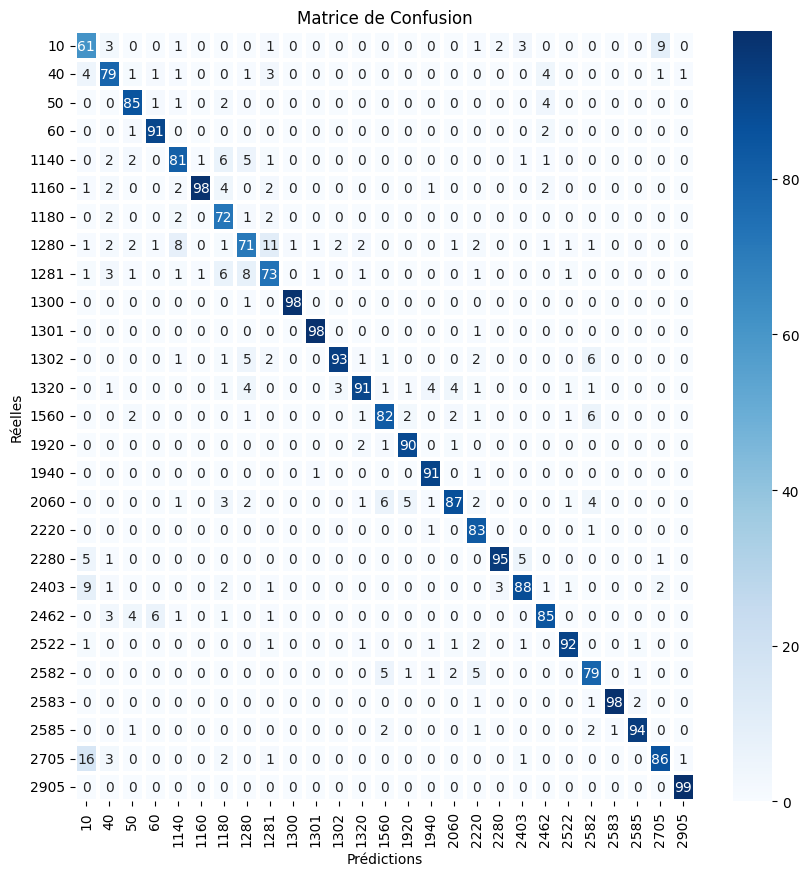

In [8]:
y_pred = model.predict([X1_test, X2_test])
y_pred_ids = np.argmax(y_pred, axis=-1)

trainer.evaluateTestResults(y_test,y_pred_ids)